In [81]:
import aipy
import glob
import healpy as hp
from matplotlib import colors
from matplotlib import pyplot as plt
import numpy as np
import os
from pygdsm import GlobalSkyModel
from scipy.interpolate import RectBivariateSpline
import uvtools

## Import Beams

In [82]:
beamfiles = sorted(glob.glob('../../hera_vivaldi_conductors_only/' + '*.txt'))  # test placeholder
freqs = np.array([float(f[47:-17]) for f in beamfiles])  # in GHz

In [83]:
THETA_AXIS = 0
PHI_AXIS = 1
VOLT_AXIS = 2

thetas, phis = np.loadtxt(beamfiles[0], skiprows=2, usecols=(THETA_AXIS,PHI_AXIS)).T
thetas = np.deg2rad(np.unique(thetas))
phis = np.deg2rad(np.unique(phis))
data = np.array([np.loadtxt(f, skiprows=2, usecols=VOLT_AXIS) for f in beamfiles])
data.shape = (-1, phis.size, thetas.size)

In [84]:
NPIX = 129
L = np.linspace(-1, 1, NPIX,endpoint=True)
M = np.linspace(-1, 1, NPIX,endpoint=True)
L.shape = (-1, 1)
M.shape = ( 1,-1)
L = L * np.ones_like(M)
M = M * np.ones_like(L)
LM = L**2 + M**2
N = np.where(LM < 1, np.sqrt(1 - LM), 0)
th = np.arccos(L).flatten()
ph = np.arctan2(M, N).flatten() - np.pi
ph = np.where(ph < 0, 2*np.pi+ph, ph)

/tmp/ipykernel_145/2824328163.py:9: RuntimeWarning: invalid value encountered in sqrt
  N = np.where(LM < 1, np.sqrt(1 - LM), 0)


In [85]:
mask = np.where(LM < 1, 1, 0)
beams = np.array([RectBivariateSpline(phis, thetas, d)(ph, th, grid=False)**2 for d in data])
beams.shape = (-1, NPIX, NPIX)
beams *= mask
print(beams.shape)

(201, 129, 129)


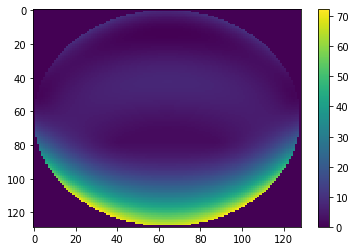

In [86]:
plt.figure()
uvtools.plot.waterfall(beams[100], mode='real')
plt.colorbar()
plt.show()

/tmp/ipykernel_145/3216336362.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10*np.log10(beams[100] / beams[100].max()))


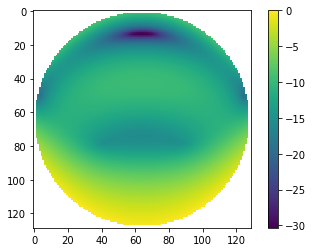

In [87]:
plt.figure()
plt.imshow(10*np.log10(beams[100] / beams[100].max()))
plt.colorbar()
plt.show()
#plt.savefig('plots/feed_beam.png',bbox_inches='tight')

## Load GSM

In [88]:
NSIDE = 64
hpb = aipy.healpix.HealpixBase(nside=NSIDE)
I_sky = np.empty((freqs.size, hpb.npix()))
gsm = GlobalSkyModel(freq_unit='GHz')
ga2eq = aipy.coord.convert_m('ga', 'eq')
for ch,f in enumerate(freqs):
    if NSIDE == 512:
        I_sky[ch] = gsm.generate(f)
    else:
        I_sky[ch] = hp.ud_grade(gsm.generate(f), nside_out=NSIDE)

In [89]:
NTIMES = 256
JD = 2459117
jds = np.linspace(JD, JD+1, NTIMES)

crd_eq = np.array(hpb.px2crd(np.arange(hpb.npix())))
antpos = np.array([[0.,0,0]]) # meters
loc = ('40:00', '0:00')
aa = aipy.amp.AntennaArray(loc, antpos)

eq2tops = []
for jd in jds:
    aa.set_jultime(jd)
    eq2tops.append(np.dot(aa.eq2top_m, ga2eq))
eq2tops = np.array(eq2tops)

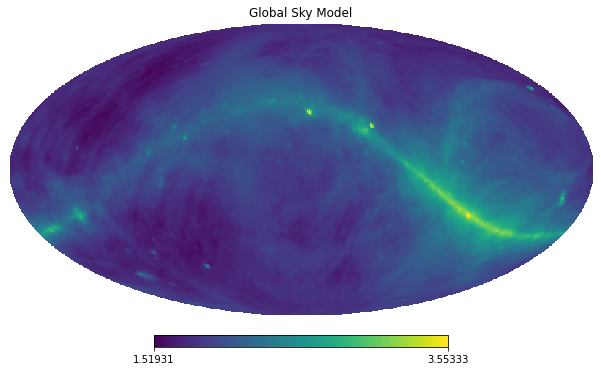

In [90]:
rot=hp.Rotator(coord=['G','C'])
hp.mollview(np.log10(rot.rotate_map_pixel(I_sky[-1])), rot=[0,30,0], title='Global Sky Model')
#plt.savefig('plots/gsm.png', bbox_inches='tight')

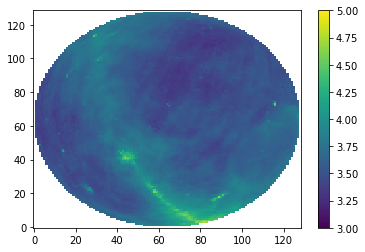

In [91]:
hpm = aipy.healpix.HealpixMap(nside=NSIDE)
hpm.map = I_sky[0]
top = (M.flatten(), L.flatten(), N.flatten())
gx,gy,gz = np.dot(np.linalg.inv(np.dot(eq2tops[150], ga2eq)), top)
img = hpm[gx,gy,gz]
img.shape = (NPIX,NPIX)
plt.figure()
uvtools.plot.waterfall(mask * img, mode='log', mx=5, drng=2, origin='lower')
_ = plt.colorbar()

In [92]:
if not os.path.exists('auto.npz'):
    #from hera_gpu.vis import vis_gpu as vis
    from hera_sim.visibilities.vis_cpu import vis_cpu as vis

    data = np.empty((NTIMES,freqs.size), dtype=np.complex64)
    for ch in range(freqs.size):
        print(ch)
        data[:,ch] = vis(antpos, freqs[ch], eq2tops, crd_eq, I_sky[ch], beams[ch:ch+1])[:,0,0]
    np.savez('auto.npz', data=data, freqs=freqs, jds=jds)
else:
    print('Reading from file')
    npz = np.load('auto.npz')
    data = npz['data']
    jds = npz['jds']
    freqs = npz['freqs']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


## Load 21cm models

In [93]:
freqs.size

201

In [94]:
def z_to_nu(z):
    nu_0 = 1420405751.768  # Hz
    return nu_0 / (z+1)

redshifts = np.loadtxt('z_EIGSEP.txt')
freqs_sampled = z_to_nu(redshifts) / 1e9  # GHz

exotic_models = np.loadtxt('T21_EIGSEP.txt') / 1e3  # mK to K

In [95]:
data.shape

(256, 201)

In [96]:
gain = beams[:,NPIX//2+1,NPIX//2+1]
avg = np.mean(data[-50:], axis=0) / gain
cal = 180 / avg[np.argmin(np.abs(freqs-0.180))]

In [107]:
exotic_models.min(axis=1)

array([-0.11165953, -0.15736483, -0.15776965, -1.9438623 , -0.09004246,
       -0.15984139, -0.02566258, -0.02724066, -0.00965414, -1.1390041 ,
       -0.11734687, -0.06956227, -6.5420416 , -1.7121258 , -0.05315161,
       -1.3684621 , -7.8336676 , -0.08276834, -0.53491445, -0.1297515 ,
       -1.5066023 , -5.2208945 , -0.12712875, -0.03496382, -0.18161766,
       -0.90357536, -0.08270374, -0.09699128, -0.1605682 , -0.15938748,
       -0.16922476, -0.12994329, -0.08469484, -0.06614402, -0.02044842,
       -0.15880225, -0.00965414, -0.112471  , -1.7366922 , -0.10111593,
       -0.28445224, -0.14429379, -0.01597841, -1.7410926 , -0.13575497,
       -0.02404344, -0.07579197, -0.13417569, -0.26549175, -0.16300288,
       -0.09786213, -0.80406633, -0.73424489, -0.28974527, -0.04621592,
       -0.01294427, -0.12890412, -0.49109319, -0.29808118, -0.07308577,
       -0.04628657, -0.15447815, -0.24331558, -3.2834899 , -0.58054052,
       -0.14770526, -0.24954103, -0.1354765 , -0.61053899, -0.03

/home/christian/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


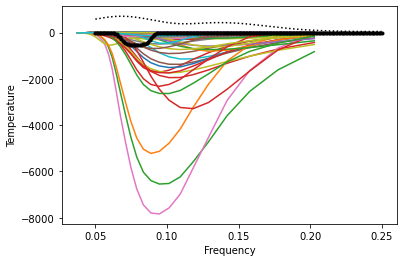

In [109]:
def gen_eor(A, nu0, w, tau):
    B = 4 * (freqs - nu0)**2 / w**2 * np.log(-1/tau * np.log((1+np.exp(-tau))/2))
    return -A * (1 - np.exp(-tau * np.exp(B))) / (1 - np.exp(-tau))

prms = {
    'A': 0.52,
    'nu0': 78.3e-3,
    'w': 20.7e-3,
    'tau': 6.5,
}
fake_eor = gen_eor(**prms)

idata = cal * data / gain + fake_eor

plt.figure()

for mdl in exotic_models:
    plt.plot(freqs_sampled, 1e3*mdl)
plt.plot(freqs, 1e3*fake_eor, 'k.-')
plt.plot(freqs, idata[0], 'k:')
#plt.plot(freqs_sampled, idata_dish[0], 'k--')

plt.xlabel('Frequency')
_ = plt.ylabel('Temperature')

NameError: name 'idata' is not defined

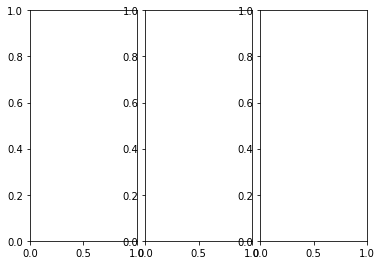

In [20]:
fig = plt.figure()
h_gap = 0.04
axarr=[fig.add_axes([0.1, 0.2, .8/3-h_gap/2, .8]), fig.add_axes([.8/3+.1, 0.2, .8/3-h_gap/2, .8]), fig.add_axes([2*.8/3+.1, 0.2, .8/3-h_gap/2, .8])]

plt.sca(axarr[0])
#plt.text(85, 0.6, '$\\times 10^{-3}$', color='k', fontsize=14)
#plt.text(55, 0.23, '$\\times 10^{-3}$', color='r', fontsize=14)

l0=plt.plot(freqs * 1e3, np.abs(idata[::50] - reor).T/1e4, color='r', lw=1, ls='-')[0]
l1=plt.plot(freqs * 1e3, np.abs(idata_dish[::50] - reord).T/1e4, color='k', lw=1, ls='-')[0]

#l2=plt.semilogy(freqs * 1e3, np.abs(idata_flattened[np.argmin(np.mean(idata_flattened, axis=1))] - reor), color='r', lw=4)[0]
#l3=plt.semilogy(freqs * 1e3, np.abs(idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reor), color='k', lw=4)[0]
l2=plt.plot(freqs * 1e3, models.T[:, ::10], lw=1, alpha=.5, color='grey')[0]
l3=plt.plot(freqs * 1e3, fake_eor, color='orange', lw=4)[0]
l5 = plt.plot(freqs*1e3, models[895], lw=2, color='purple')[0]
#for m in range(3):
    #plt.plot(freqs * 1e3, (Vu[m] @ idata[np.argmin(np.mean(idata_flattened, axis=1))] - reor)*Vu[m] / 1e2, color='r', lw=1)
#    plt.plot(freqs * 1e3, Vu[m]*2, color='r', lw=1)

    
#for m in range(3):
    #plt.plot(freqs * 1e3, (Vud[m] @ idata_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord)*Vud[m] / 1e2, color='k', lw=1)
#    plt.plot(freqs * 1e3, Vud[m]*2, color='k', lw=1)

    
summed = np.zeros_like(freqs,dtype=complex)
#for m in range(3):
#    summed+=Vu[m] @ (idata[np.argmin(np.mean(idata_flattened, axis=1))] - reor)*Vu[m] / 1e4
#plt.plot(freqs*1e3, summed, ls='--', color='r')
    

#l5=plt.semilogy(freqs * 1e3, np.abs(2.73/10+fake_eor), color='orange', ls=':', lw=4)[0]

plt.ylim(-.6, 1)
#l7=plt.plot(freqs * 1e3, np.abs(idata[np.argmin(np.mean(idata_flattened, axis=1))]) / np.sqrt(DF * 1e9 * tint), color='green', ls='--', lw=4)[0]

plt.ylabel('|T| [K]', fontsize=18)
plt.grid()
#plt.ylim(1e-3, 5e3)
plt.xlim(55, 245)
plt.gca().tick_params(labelsize=16)
plt.xlabel("$\\nu$ [MHz]", fontsize=18)


plt.sca(axarr[2])
plt.semilogy(np.abs(np.dot(V, rmodels.T))[:, ::50], lw=1, alpha=.5, color='grey')
x = np.abs(np.dot(V, (idata_flattened[np.argmin(np.mean(idata_flattened, axis=1))] - reor).T))
threshold_fg = np.where(x < x.max()*1e-4)[0].min()
noise_level = np.sqrt(np.diag(V.T @ np.diag(np.abs((idata[np.argmin(np.mean(idata_flattened, axis=1))]) / np.sqrt(DF * 1e9 * tint)) ** 2.) @ V))

#plt.semilogy(np.abs(np.dot(Vd, (idata[np.argmin(np.mean(idata_flattened, axis=1))] - reor).T)),
#             'r', lw=4)[0]
l0=plt.semilogy(x, 'r-', lw=4)[0]
plt.semilogy(np.abs(np.dot(V, reor)),color='orange', lw=4)
l4=plt.semilogy(noise_level, color='green', ls='--', lw=4)[0]
plt.semilogy(np.abs(V @ rmodels[895]), lw=2, color='purple')

#index_tm4 = np.argmin(np.dot(V, ))
#plt.axvline(threshold_fg, color='r', ls='--')
plt.grid()
#plt.gca().set_xticklabels([])
plt.gca().tick_params(labelsize=16)
plt.ylim(1e-3, 5e3)
plt.xlim(0,45)
plt.xlabel('Foreground Eigenmode', fontsize=18)
#plt.gca().set_yticklabels([])
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position('right')
plt.ylabel('|T| [K]', fontsize=18)



plt.sca(axarr[1])
#plt.semilogy(np.abs(np.dot(Vd, )))
l3=plt.semilogy(np.abs(np.dot(Vd, rmodelsd.T))[:, ::50], lw=1, alpha=.5, color='grey')[0]
xd = np.abs(np.dot(Vd, (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T))
threshold_fg_d = np.where(xd < xd.max()*1e-4)[0].min()
noise_level = np.sqrt(np.diag(Vd.T @ np.diag(np.abs((idata_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))]) / np.sqrt(DF * 1e9 * tint)) ** 2.) @ Vd))

#l0=plt.semilogy(np.abs(np.dot(Vd, (idata_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T)),
#             'k', lw=4)[0]
l1=plt.semilogy(np.abs(np.dot(Vd, (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T)),
             'k-', lw=4)[0]
l3=plt.semilogy(np.abs(np.dot(Vd, reord)),color='orange', lw=4, ls='-')[0]
plt.semilogy(np.abs(Vd @ rmodelsd[895]), lw=2, color='purple')
#l2=plt.semilogy(freqs * 1e3, np.abs(Vd @ (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reor) / np.sqrt(DF * 1e9 * tint)), color='green', ls='--', lw=4)[0]
plt.semilogy(noise_level, color='green', ls='--', lw=4)


plt.grid()
plt.gca().tick_params(labelsize=16)
#plt.axvline(threshold_fg_d, color='r', ls='--')

plt.ylim(1e-3, 5e3)
plt.xlim(0,45)
#plt.gca().set_xticklabels([])
plt.xlabel('Foreground Eigenmode', fontsize=18)
plt.gca().set_yticklabels([])

threshold_21cm = np.where(np.abs(np.sqrt(np.abs(Sm)) < .1 * np.sqrt(np.abs(Sm)).max()))[0].min()
threshold_21cmd = np.where(np.abs(np.sqrt(np.abs(Smd)) < .1 * np.sqrt(np.abs(Smd)).max()))[0].min()



plt.gcf().set_size_inches(14, 6)


fig.legend((l0,l1,l3, l5,l2, l4), ('Vivaldi Foregrounds', 'Dish Foregrounds', 'EDGES 21cm', 'Nominal 21cm', 'Other 21cm', 'Thermal Noise'), loc='lower center' ,ncol=6, fontsize=12)


plt.savefig('plots/pc_plot_w_frequency.png', bbox_inches='tight')